In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

balanced_data = pd.read_csv('HTA_balanceado.csv')
y = balanced_data['riesgo_hipertension']
x = balanced_data.drop('riesgo_hipertension', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
Peso_randomforest = RandomForestClassifier(n_estimators=150, max_depth=20, random_state=42)
Peso_randomforest.fit(x_train, y_train)

importances = Peso_randomforest.feature_importances_
feature_names = x.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print("Importancia de características:")
print(feature_importance.sort_values(by='Importance', ascending=False))

Importancia de características:
                             Feature  Importance
32                     masa_corporal    0.262143
30                  tension_arterial    0.218401
24                    medida_cintura    0.146138
22                              peso    0.110943
33                   actividad_total    0.059391
23                          estatura    0.029163
31                       sueno_horas    0.024165
0                               sexo    0.023266
1                               edad    0.022442
14     valor_hemoglobina_glucosilada    0.011298
13        resultado_glucosa_promedio    0.009873
11                    valor_insulina    0.007573
7               valor_colesterol_ldl    0.007022
12               valor_trigliceridos    0.006684
10                 resultado_glucosa    0.006208
8             valor_colesterol_total    0.005704
2          concentracion_hemoglobina    0.005276
6               valor_colesterol_hdl    0.005254
9                     valor_creatina 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.metrics import accuracy_score
dataframe = pd.read_csv('HTA_balanceado.csv')


Reporte de clasificación:
              precision    recall  f1-score   support

  Sin riesgo       0.97      0.99      0.98       479
  Con riesgo       0.99      0.97      0.98       524

    accuracy                           0.98      1003
   macro avg       0.98      0.98      0.98      1003
weighted avg       0.98      0.98      0.98      1003



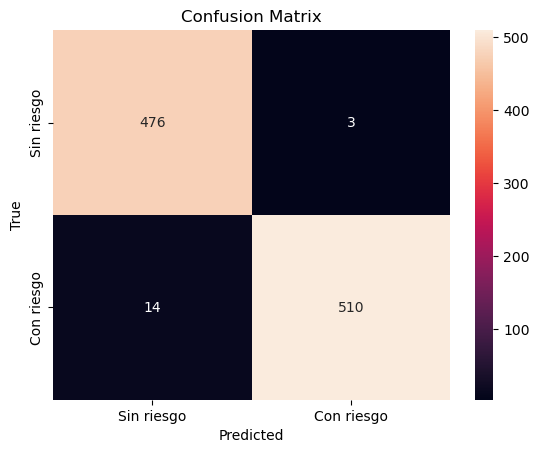

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

balanced_data = pd.read_csv('HTA_balanceado.csv')

y = balanced_data['riesgo_hipertension']
x = balanced_data[['masa_corporal', 'tension_arterial', 'medida_cintura', 'peso', 'actividad_total', 'edad', 'estatura', 'sexo', 'sueno_horas', 'valor_hemoglobina_glucosilada', 'valor_insulina', 'resultado_glucosa_promedio', 'concentracion_hemoglobina', 'valor_colesterol_ldl', 'valor_trigliceridos']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=127, max_depth=20, random_state=42)
model.fit(x_train, y_train)

predicciones = model.predict(x_test)

clasificadores = {0: "Sin riesgo", 1: "Con riesgo"}
target_names = list(clasificadores.values())

print("Reporte de clasificación:")
print(classification_report(y_test, predicciones, target_names=target_names))

#Matriz
matriz = confusion_matrix(y_test, predicciones)
sns.heatmap(matriz, annot=True, fmt="d", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

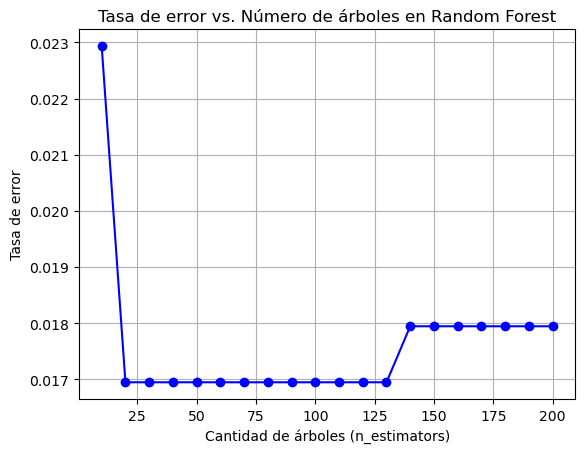

In [4]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

errores = []

# Probar con diferentes cantidades de árboles
for n in range(10, 201, 10):
    modelo = RandomForestClassifier(n_estimators=n, random_state=42)
    modelo.fit(x_train, y_train)
    predicciones = modelo.predict(x_test)
    error = 1 - accuracy_score(y_test, predicciones)  # tasa de error = 1 - accuracy
    errores.append(error)

# Graficar la tasa de error
plt.plot(range(10, 201, 10), errores, marker='o', color='blue')
plt.xlabel('Cantidad de árboles (n_estimators)')
plt.ylabel('Tasa de error')
plt.title('Tasa de error vs. Número de árboles en Random Forest')
plt.grid(True)
plt.show()

In [5]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [6]:
from flask import Flask, jsonify, request
from threading import Thread
import time
app = Flask(__name__)

try:
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    print("Modelo cargado correctamente")
except Exception as e:
    print("Error al cargar el modelo:", str(e))
    modelo = None

@app.route('/predict', methods=['POST'])
def predict():
    try:
        req_json = request.get_json()
        print("Datos recibidos en la API:", req_json)
        input_data = pd.DataFrame(req_json)
        print("DataFrame creado:", input_data.to_dict())
    except Exception as e:
        print("Error al procesar JSON:", str(e))
        return jsonify({'error': str(e)}), 400

    if input_data.empty:
        print("Error: DataFrame vacío")
        return jsonify({'error': 'No data provided'}), 400

    expected_columns = ['masa_corporal', 'tension_arterial', 'medida_cintura', 'peso', 'actividad_total', 'edad', 'estatura', 'sexo', 'sueno_horas', 'valor_hemoglobina_glucosilada', 'valor_insulina', 'resultado_glucosa_promedio', 'concentracion_hemoglobina', 'valor_colesterol_ldl', 'valor_trigliceridos']
    if not all(col in input_data.columns for col in expected_columns):
        print("Error: Columnas faltantes", input_data.columns.tolist())
        return jsonify({'error': 'Missing required columns'}), 400
    
    try:
        predictions = model.predict(input_data)
        predictions = predictions.astype(int)
        predictions = [clasificadores[pred] for pred in predictions]
        probabilities = model.predict_proba(input_data).tolist()
        print("Predicciones realizadas:", predictions)
    except Exception as e:
        print("Error al hacer predicciones:", str(e))
        return jsonify({'error': 'Prediction failed'}), 500

    response = jsonify({
        'predictions': predictions,
        'probabilities': probabilities
    })
    response.status_code = 200
    print("Respuesta enviada:", response.get_json())
    return response

def run_flask():
    app.run(port=8001, use_reloader=False)

if __name__ == '__main__':
    Thread(target=run_flask).start()
    time.sleep(3)

Modelo cargado correctamente
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8001
Press CTRL+C to quit


In [7]:
test_data = pd.DataFrame({
    'masa_corporal': [34],
    'tension_arterial': [107],
    'medida_cintura': [88],
    'peso': [74.5],
    'actividad_total': [2],
    'edad': [21],
    'estatura': [147.3],
    'sexo': [2],
    'sueno_horas': [4],
    'valor_hemoglobina_glucosilada': [4],
    'valor_insulina': [4],
    'resultado_glucosa_promedio': [64],
    'concentracion_hemoglobina': [10],
    'valor_colesterol_ldl': [86],
    'valor_trigliceridos': [86]
})

data_json = test_data.to_json(orient='records')

print("Datos enviados en el POST:")
print(data_json)

headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

try:
    print("Enviando solicitud POST a http://localhost:8001/predict")
    response = requests.post('http://localhost:8001/predict', data=data_json, headers=headers)
    print('\nConsulta a la API:')
    print('Status:', response.status_code)
    print('Respuesta:', response.json())
except Exception as e:
    print(f"Error al consultar la API: {e}")

Datos enviados en el POST:
[{"masa_corporal":34,"tension_arterial":107,"medida_cintura":88,"peso":74.5,"actividad_total":2,"edad":21,"estatura":147.3,"sexo":2,"sueno_horas":4,"valor_hemoglobina_glucosilada":4,"valor_insulina":4,"resultado_glucosa_promedio":64,"concentracion_hemoglobina":10,"valor_colesterol_ldl":86,"valor_trigliceridos":86}]
Enviando solicitud POST a http://localhost:8001/predict


127.0.0.1 - - [10/Aug/2025 23:52:55] "POST /predict HTTP/1.1" 200 -


Datos recibidos en la API: [{'masa_corporal': 34, 'tension_arterial': 107, 'medida_cintura': 88, 'peso': 74.5, 'actividad_total': 2, 'edad': 21, 'estatura': 147.3, 'sexo': 2, 'sueno_horas': 4, 'valor_hemoglobina_glucosilada': 4, 'valor_insulina': 4, 'resultado_glucosa_promedio': 64, 'concentracion_hemoglobina': 10, 'valor_colesterol_ldl': 86, 'valor_trigliceridos': 86}]
DataFrame creado: {'masa_corporal': {0: 34}, 'tension_arterial': {0: 107}, 'medida_cintura': {0: 88}, 'peso': {0: 74.5}, 'actividad_total': {0: 2}, 'edad': {0: 21}, 'estatura': {0: 147.3}, 'sexo': {0: 2}, 'sueno_horas': {0: 4}, 'valor_hemoglobina_glucosilada': {0: 4}, 'valor_insulina': {0: 4}, 'resultado_glucosa_promedio': {0: 64}, 'concentracion_hemoglobina': {0: 10}, 'valor_colesterol_ldl': {0: 86}, 'valor_trigliceridos': {0: 86}}
Predicciones realizadas: ['Con riesgo']
Respuesta enviada: {'predictions': ['Con riesgo'], 'probabilities': [[0.16535433070866143, 0.8346456692913385]]}

Consulta a la API:
Status: 200
Respu